# Logistic Regression in Theano

Credits: Forked from [summerschool2015](https://github.com/mila-udem/summerschool2015) by mila-udem

This notebook is inspired from [the tutorial on logistic regression](http://deeplearning.net/tutorial/logreg.html) on [deeplearning.net](http://deeplearning.net).

In this notebook, we show how Theano can be used to implement the most basic classifier: the **logistic regression**. We start off with a quick primer of the model, which serves both as a refresher but also to anchor the notation and show how mathematical expressions are mapped onto Theano graphs.

In the deepest of machine learning traditions, this tutorial will tackle the exciting problem of MNIST digit classification.

## Get the data

In the mean time, let's just download a pre-packaged version of MNIST, and load each split of the dataset as NumPy ndarrays.

In [2]:
import os
import requests
import gzip
import six
from six.moves import cPickle

if not os.path.exists('mnist.pkl.gz'):
    r = requests.get('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
    with open('mnist.pkl.gz', 'wb') as data_file:
        data_file.write(r.content)

with gzip.open('mnist.pkl.gz', 'rb') as data_file:
    if six.PY3:
        train_set, valid_set, test_set = cPickle.load(data_file, encoding='latin1')
    else:
        train_set, valid_set, test_set = cPickle.load(data_file)

train_set_x, train_set_y = train_set
valid_set_x, valid_set_y = valid_set
test_set_x, test_set_y = test_set

## The model
Logistic regression is a probabilistic, linear classifier. It is parametrized
by a weight matrix $W$ and a bias vector $b$. Classification is
done by projecting an input vector onto a set of hyperplanes, each of which
corresponds to a class. The distance from the input to a hyperplane reflects
the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $x$ is a member of a
class $i$, a value of a stochastic variable $Y$, can be written as:

$$P(Y=i|x, W,b) = softmax_i(W x + b) = \frac {e^{W_i x + b_i}} {\sum_j e^{W_j x + b_j}}$$

The model's prediction $y_{pred}$ is the class whose probability is maximal, specifically:

$$  y_{pred} = {\rm argmax}_i P(Y=i|x,W,b)$$

Now, let us define our input variables. First, we need to define the dimension of our tensors:
- `n_in` is the length of each training vector,
- `n_out` is the number of classes.

Our variables will be:
- `x` is a matrix, where each row contains a different example of the dataset. Its shape is `(batch_size, n_in)`, but `batch_size` does not have to be specified in advance, and can change during training.
- `W` is a shared matrix, of shape `(n_in, n_out)`, initialized with zeros. Column `k` of `W` represents the separation hyperplane for class `k`.
- `b` is a shared vector, of length `n_out`, initialized with zeros. Element `k` of `b` represents the free parameter of hyperplane `k`.

In [3]:
import numpy
import theano
from theano import tensor

# Size of the data
n_in = 28 * 28
# Number of classes
n_out = 10

x = tensor.matrix('x')
W = theano.shared(value=numpy.zeros((n_in, n_out), dtype=theano.config.floatX),
                  name='W',
                  borrow=True)
b = theano.shared(value=numpy.zeros((n_out,), dtype=theano.config.floatX),
                  name='b',
                  borrow=True)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


Now, we can build a symbolic expression for the matrix of class-membership probability (`p_y_given_x`), and for the class whose probability is maximal (`y_pred`).

In [4]:
p_y_given_x = tensor.nnet.softmax(tensor.dot(x, W) + b)
y_pred = tensor.argmax(p_y_given_x, axis=1)

## Defining a loss function
Learning optimal model parameters involves minimizing a loss function. In the
case of multi-class logistic regression, it is very common to use the negative
log-likelihood as the loss. This is equivalent to maximizing the likelihood of the
data set $\cal{D}$ under the model parameterized by $\theta$. Let
us first start by defining the likelihood $\cal{L}$ and loss
$\ell$:

$$\mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
     \sum_{i=0}^{|\mathcal{D}|} \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
   \ell (\theta=\{W,b\}, \mathcal{D}) = - \mathcal{L} (\theta=\{W,b\}, \mathcal{D})
$$

Again, we will express those expressions using Theano. We have one additional input, the actual target class `y`:
- `y` is an input vector of integers, of length `batch_size` (which will have to match the length of `x` at runtime). The length of `y` can be symbolically expressed by `y.shape[0]`.
- `log_prob` is a `(batch_size, n_out)` matrix containing the log probabilities of class membership for each example.
- `arange(y.shape[0])` is a symbolic vector which will contain `[0,1,2,... batch_size-1]`
- `log_likelihood` is a vector containing the log probability of the target, for each example.
- `loss` is the mean of the negative `log_likelihood` over the examples in the minibatch.

In [5]:
y = tensor.lvector('y')
log_prob = tensor.log(p_y_given_x)
log_likelihood = log_prob[tensor.arange(y.shape[0]), y]
loss = - log_likelihood.mean()

## Training procedure
This notebook will use the method of stochastic gradient descent with mini-batches (MSGD) to find values of `W` and `b` that minimize the loss.

We can let Theano compute symbolic expressions for the gradient of the loss wrt `W` and `b`.

In [6]:
g_W, g_b = theano.grad(cost=loss, wrt=[W, b])

`g_W` and `g_b` are symbolic variables, which can be used as part of a computation graph. In particular, let us define the expressions for one step of gradient descent for `W` and `b`, for a fixed learning rate.

In [7]:
learning_rate = numpy.float32(0.13)
new_W = W - learning_rate * g_W
new_b = b - learning_rate * g_b

We can then define **update expressions**, or pairs of (shared variable, expression for its update), that we will use when compiling the Theano function. The updates will be performed each time the function gets called.

The following function, `train_model`, returns the loss on the current minibatch, then changes the values of the shared variables according to the update rules. It needs to be passed `x` and `y` as inputs, but not the shared variables, which are implicit inputs.

The entire learning algorithm thus consists in looping over all examples in the dataset, considering all the examples in one minibatch at a time, and repeatedly calling the `train_model` function.

In [8]:
train_model = theano.function(inputs=[x, y],
                              outputs=loss,
                              updates=[(W, new_W),
                                       (b, new_b)])

### Testing the model
When testing the model, we are interested in the number of misclassified examples (and not only in the likelihood). Here, we build a symbolic expression for retrieving the number of misclassified examples in a minibatch.

This will also be useful to apply on the validation and testing sets, in order to monitor the progress of the model during training, and to do early stopping.

In [9]:
misclass_nb = tensor.neq(y_pred, y)
misclass_rate = misclass_nb.mean()

test_model = theano.function(inputs=[x, y],
                             outputs=misclass_rate)

## Training the model
Here is the main training loop of the algorithm:
- For each *epoch*, or pass through the training set
  - split the training set in minibatches, and call `train_model` on each minibatch
  - split the validation set in minibatches, and call `test_model` on each minibatch to measure the misclassification rate
  - if the misclassification rate has not improved in a while, stop training
- Measure performance on the test set

The **early stopping procedure** is what decide whether the performance has improved enough. There are many variants, and we will not go into the details of this one here.

We first need to define a few parameters for the training loop and the early stopping procedure.

In [10]:
## Define a couple of helper variables and functions for the optimization
batch_size = 500
# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.shape[0] // batch_size
n_valid_batches = valid_set_x.shape[0] // batch_size
n_test_batches = test_set_x.shape[0] // batch_size

def get_minibatch(i, dataset_x, dataset_y):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_x = dataset_x[start_idx:end_idx]
    batch_y = dataset_y[start_idx:end_idx]
    return (batch_x, batch_y)

## early-stopping parameters
# maximum number of epochs
n_epochs = 1000
# look as this many examples regardless
patience = 5000
# wait this much longer when a new best is found
patience_increase = 2
# a relative improvement of this much is considered significant
improvement_threshold = 0.995

# go through this many minibatches before checking the network on the validation set;
# in this case we check every epoch
validation_frequency = min(n_train_batches, patience / 2)

In [11]:
import timeit
from six.moves import xrange

best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0
while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):
        minibatch_x, minibatch_y = get_minibatch(minibatch_index, train_set_x, train_set_y)
        minibatch_avg_cost = train_model(minibatch_x, minibatch_y)

        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index
        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = []
            for i in xrange(n_valid_batches):
                valid_xi, valid_yi = get_minibatch(i, valid_set_x, valid_set_y)
                validation_losses.append(test_model(valid_xi, valid_yi))
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch,
                   minibatch_index + 1,
                   n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss

                # test it on the test set
                test_losses = []
                for i in xrange(n_test_batches):
                    test_xi, test_yi = get_minibatch(i, test_set_x, test_set_y)
                    test_losses.append(test_model(test_xi, test_yi))

                test_score = numpy.mean(test_losses)
                print('     epoch %i, minibatch %i/%i, test error of  best model %f %%' %
                      (epoch,
                       minibatch_index + 1,
                       n_train_batches,
                       test_score * 100.))

                # save the best parameters
                numpy.savez('best_model.npz', W=W.get_value(), b=b.get_value())

        if patience <= iter:
            done_looping = True
            break

end_time = timeit.default_timer()
print('Optimization complete with best validation score of %f %%, '
      'with test performance %f %%' %
      (best_validation_loss * 100., test_score * 100.))

print('The code ran for %d epochs, with %f epochs/sec' %
      (epoch, 1. * epoch / (end_time - start_time)))

epoch 1, minibatch 100/100, validation error 11.890000 %
     epoch 1, minibatch 100/100, test error of  best model 12.170000 %
epoch 2, minibatch 100/100, validation error 10.520000 %
     epoch 2, minibatch 100/100, test error of  best model 10.940000 %
epoch 3, minibatch 100/100, validation error 9.940000 %
     epoch 3, minibatch 100/100, test error of  best model 10.210000 %
epoch 4, minibatch 100/100, validation error 9.480000 %
     epoch 4, minibatch 100/100, test error of  best model 9.820000 %
epoch 5, minibatch 100/100, validation error 9.230000 %
     epoch 5, minibatch 100/100, test error of  best model 9.510000 %
epoch 6, minibatch 100/100, validation error 9.100000 %
     epoch 6, minibatch 100/100, test error of  best model 9.280000 %
epoch 7, minibatch 100/100, validation error 8.820000 %
     epoch 7, minibatch 100/100, test error of  best model 9.100000 %
epoch 8, minibatch 100/100, validation error 8.750000 %
     epoch 8, minibatch 100/100, test error of  best mode

## Visualization
You can visualize the columns of `W`, which correspond to the separation hyperplanes for each class.

(-0.5, 143.5, 56.5, -0.5)

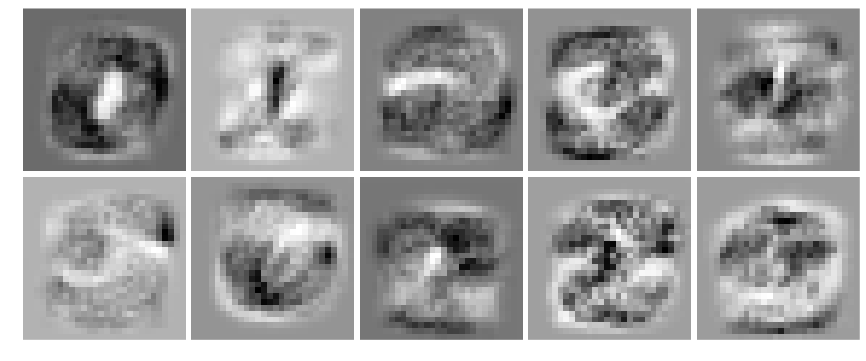

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import tile_raster_images

plt.clf()

# Increase the size of the figure
plt.gcf().set_size_inches(15, 10)

plot_data = tile_raster_images(W.get_value(borrow=True).T,
                               img_shape=(28, 28), tile_shape=(2, 5), tile_spacing=(1, 1))
plt.imshow(plot_data, cmap='Greys', interpolation='none')
plt.axis('off')